# This is a sample code snipped for the "Accelerated Neural Network Initialization via Distributed Training of Symmetrically Partitioned Models"

Below is an example illustrating the approach described in the article. This example focuses solely on splitting the model into two parts. We will train each part separately on the split dataset, then merge them to train the complete model. Finally, we will compare our approach to a normal training method and highlight the differences.

This code snippet is meant to help better understand the article and is intended for testing purposes. Further optimizations and refactoring could lead to a more robust implementation.

In [21]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Splitting cifar100 into 2 horizontal spaces")


Num GPUs Available:  1
Splitting cifar100 into 2 horizontal spaces


In [22]:
import numpy as np
import pandas as pd
# import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from keras.layers import Activation
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split


## Global configuration and dataset loading

- Sets hyperparameters and architectural sizes (filters, dense sizes).
- Load the cifar10 dataset for final testing and validation.


In [23]:
NUM_CLASSES = 100
NUM_SPLITS_W = 2
NUM_SPLITS_H = 0
NUM_SPLITS = NUM_SPLITS_W + NUM_SPLITS_H

INPUT_SHAPE = 32
    
CONV1_FILTERS = 64
CONV2_FILTERS = 32

DENSE1_SIZE = 64
DENSE2_SIZE = 64

dataset = keras.datasets.cifar10.load_data()
((X_train, y_train), (X_test, y_test)) = dataset
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
y_train = keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)


# Splits the input dataset horizontally into multiple subsets.

This function takes a dataset (defaulting to CIFAR-100) and splits the training and testing images
    into `num_splits_h` horizontal subsets.  This is a key step in the described approach to
    distributed training and accelerated initialization.  The goal is to train separate parts of the model
    on these subsets and later merge them for full training.

In [24]:
def splitData(dataset = keras.datasets.cifar100.load_data(label_mode="coarse"), num_splits_h=2, num_splits_w=0):
    (X_train, y_train), (X_test, y_test) = dataset
    
    split_shape = INPUT_SHAPE // num_splits_h
    
    print(f"ratio: wh-{split_shape} set-{num_splits_h} test-{split_shape*num_splits_h == INPUT_SHAPE}")
    print(f"train shape: {X_train.shape}")

    x_train_arr = []
    x_test_arr = []
    for i in range(num_splits_h):
        x_sub_train = X_train[:, i*split_shape:(i+1)*split_shape, :].astype('float32') / 255
        x_sub_test = X_test[:, i*split_shape:(i+1)*split_shape, :].astype('float32') / 255
        x_train_arr.append(x_sub_train)
        x_test_arr.append(x_sub_test)

    print(f"split shape: {x_train_arr[0].shape}")
    
    y_train = keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
    y_test = keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)
    
    return x_train_arr, y_train, x_test_arr, y_test

# Defines an CNN model with partitioned filters and sizes for distributed training.

This function constructs a convolutional neural network.  It modifies the standard
    architecture by dividing the number of filters in convolutional layers (CONV1_FILTERS, CONV2_FILTERS)
    and the size of dense layers (DENSE1_SIZE, DENSE2_SIZE) by `num_splits`. This partitioning is
    intended to enable distributed training, where different parts of the model can be trained on
    different subsets of the data.

In [25]:

def create_cnn(input_shape=(224, 224, 3), num_classes=NUM_CLASSES, num_splits=2):
    conv1_f = CONV1_FILTERS // num_splits
    conv2_f = CONV2_FILTERS // num_splits
    dense1_s = DENSE1_SIZE // num_splits
    dense2_s = DENSE2_SIZE // num_splits
    # [48,128,96,192,64]

    model = Sequential()
    model.add(Conv2D(conv1_f, (4, 4), padding='same', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Conv2D(conv1_f, (2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Conv2D(conv2_f, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Conv2D(conv2_f, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Dropout(0.15))

    model.add(Flatten())
    model.add(Dense(DENSE1_SIZE, trainable=True))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(dense2_s, trainable=True))
    model.add(Activation('tanh'))
    # model.add(Dropout(0.25))
    model.add(Dense(num_classes, activation='softmax'))

    summary_str = []
    model.summary(print_fn=lambda x: summary_str.append(x))
        # Print layer index along with the existing summary
    summary_str = summary_str[0].split('\n')
    i = 0
    for x, line in enumerate(summary_str):
            if 'None' in line:
                if i < 10:
                    print(f" {i} {line}")
                else:
                    print(f"{i} {line}")
                i+=1
            elif '─────────' in line:
                print(f"───{line}")
            else:
                print(f"   {line}")

    return model

# Spawn split models
- Creates num_splits separate instances of the partitioned CNN with the given input shape (the split-size).
- Compiles each model with Adam + categorical cross-entropy and accuracy metric.
- Returns a list of compiled models.

In [26]:
def genModels(num_splits=NUM_SPLITS):
    models = []
    for i in range(num_splits):
        model = create_cnn(input_shape, num_splits=num_splits)
        model.compile(optimizer=Adam(), # learning_rate=0.01 # 0.001
              loss='categorical_crossentropy',
              metrics=['accuracy'])
        models.append(model)
    return models


# Train each split-model on its corresponding data slice
- Iterates through models, feeding x_train_arr[i] as input and the shared y_train labels.
- Uses validation on the corresponding test split.
- Returns the trained models and their Keras History objects for plotting/evaluation.

In [27]:

def trainModels(models, data, epochs=1, callbacks=[]):
    x_train_arr, y_train, x_test_arr, y_test = data
    histories = []
    for i, model in enumerate(models):
        history = model.fit(x_train_arr[i], y_train, epochs=epochs, batch_size=128, validation_data=(x_test_arr[i], y_test), callbacks=callbacks)
        histories.append(history)
    return models, histories


# Compute input_shape for split models + split the data + generate models

In [28]:
input_shape = (
    INPUT_SHAPE // NUM_SPLITS_W if NUM_SPLITS_W != 0 else INPUT_SHAPE,
    INPUT_SHAPE // NUM_SPLITS_H if NUM_SPLITS_H != 0 else INPUT_SHAPE,
    3)

data = splitData(num_splits_h=NUM_SPLITS_W)
models = genModels()

ratio: wh-16 set-2 test-True
train shape: (50000, 32, 32, 3)
split shape: (50000, 16, 32, 3)


   Model: "sequential_4"
   ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
   ┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
   ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
 0 │ conv2d_16 (Conv2D)              │ (None, 16, 32, 32)     │         1,568 │
───├─────────────────────────────────┼────────────────────────┼───────────────┤
 1 │ max_pooling2d_8 (MaxPooling2D)  │ (None, 8, 16, 32)      │             0 │
───├─────────────────────────────────┼────────────────────────┼───────────────┤
 2 │ activation_24 (Activation)      │ (None, 8, 16, 32)      │             0 │
───├─────────────────────────────────┼────────────────────────┼───────────────┤
 3 │ dropout_20 (Dropout)            │ (None, 8, 16, 32)      │             0 │
───├─────────────────────────────────┼────────────────────────┼───────────────┤
 4 │ conv2d_17 (Conv2D)              │ (None, 8, 16, 32)      │         4,128 │
───├───────────

   Model: "sequential_5"
   ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
   ┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
   ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
 0 │ conv2d_20 (Conv2D)              │ (None, 16, 32, 32)     │         1,568 │
───├─────────────────────────────────┼────────────────────────┼───────────────┤
 1 │ max_pooling2d_10 (MaxPooling2D) │ (None, 8, 16, 32)      │             0 │
───├─────────────────────────────────┼────────────────────────┼───────────────┤
 2 │ activation_30 (Activation)      │ (None, 8, 16, 32)      │             0 │
───├─────────────────────────────────┼────────────────────────┼───────────────┤
 3 │ dropout_25 (Dropout)            │ (None, 8, 16, 32)      │             0 │
───├─────────────────────────────────┼────────────────────────┼───────────────┤
 4 │ conv2d_21 (Conv2D)              │ (None, 8, 16, 32)      │         4,128 │
───├───────────

# Train split models

- Optional EarlyStopping callback defined but not used in the call shown.

In [29]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

models, histories = trainModels(models, data, epochs=50, callbacks=[]) #[callback]
# model1.save('./s4-model1.keras')

Epoch 1/50


'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


366/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0481 - loss: 3.3784

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0482 - loss: 3.3625

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.0482 - loss: 3.3619 - val_accuracy: 0.0500 - val_loss: 3.0082
Epoch 2/50
 61/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0521 - loss: 3.0087

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0506 - loss: 3.0072 - val_accuracy: 0.0500 - val_loss: 3.0029
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0501 - loss: 3.0024 - val_accuracy: 0.0500 - val_loss: 2.9994
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0593 - loss: 2.9837 - val_accuracy: 0.1546 - val_loss: 2.7500
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1533 - loss: 2.7274 - val_accuracy: 0.1888 - val_loss: 2.6171
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1940 - loss: 2.5968 - val_accuracy: 0.2244 - val_loss: 2.5194
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2176 - loss: 2.5237 - val_accuracy: 0.2352 - val_loss: 2.4655
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2324 - loss: 2.4829 - val_accuracy: 0.2518 - val_loss: 2.4115
Epoch 9/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2426 - loss: 2.4447 - val_accuracy: 0.2640 - val_

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


373/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0476 - loss: 3.4131

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0478 - loss: 3.4005

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.0478 - loss: 3.3998 - val_accuracy: 0.0500 - val_loss: 3.0069
Epoch 2/50
 59/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0504 - loss: 3.0087

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0495 - loss: 3.0067 - val_accuracy: 0.0765 - val_loss: 2.9735
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0906 - loss: 2.9369 - val_accuracy: 0.1318 - val_loss: 2.8067
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1484 - loss: 2.7600 - val_accuracy: 0.1936 - val_loss: 2.6332
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1849 - loss: 2.6460 - val_accuracy: 0.2201 - val_loss: 2.5483
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2178 - loss: 2.5517 - val_accuracy: 0.2334 - val_loss: 2.4970
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2381 - loss: 2.4843 - val_accuracy: 0.2596 - val_loss: 2.4098
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2486 - loss: 2.4456 - val_accuracy: 0.2594 - val_loss: 2.4113
Epoch 9/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2607 - loss: 2.4047 - val_accuracy: 0.2819 - val_

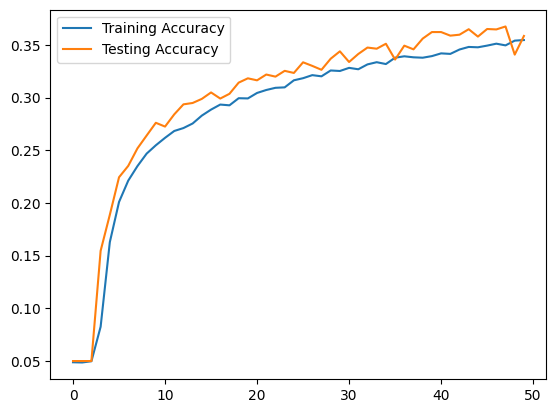

101/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3590 - loss: 2.0941

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 999us/step - accuracy: 0.3607 - loss: 2.0883
Test accuracy[0]: 0.36


In [30]:

def pltHistory(data, models, max=1):
    x_train_arr, y_train, x_test_arr, y_test = data
    
    # Plot training and testing accuracy and loss
    for i in range(max):
        plt.plot(histories[i].history['accuracy'], label='Training Accuracy')
        plt.plot(histories[i].history['val_accuracy'], label='Testing Accuracy')
        plt.legend()
        plt.show()
    
        # Evaluate the model on the test set
        test_loss, test_acc = models[i].evaluate(x_test_arr[i], y_test)
        print(f'Test accuracy[{i}]: {test_acc:.2f}')
        
pltHistory(data, models, 1)

# CNN-Combined: combined (full-image) model
- Defines a bigger CNN model that expects the full image (INPUT_SHAPE x INPUT_SHAPE x 3).
- Uses a mix of full-size and split-size layers to align with how you’ll merge weights from the smaller models.
- Ends with NUM_CLASSES output units and softmax.

In [31]:
def create_cnn_concatenated(input_shape=(224, 224, 3), num_classes=NUM_CLASSES, num_splits=2):
    CONV1_FILTERS = 64
    CONV2_FILTERS = 32

    DENSE1_SIZE = 64
    DENSE2_SIZE = 32 # 32 for other results

    conv1_f = CONV1_FILTERS // num_splits
    conv2_f = CONV2_FILTERS // num_splits
    dense1_s = DENSE1_SIZE // num_splits
    dense2_s = DENSE2_SIZE // num_splits
    # [48,128,96,192,64]

    model = Sequential()
    model.add(Conv2D(CONV1_FILTERS, (4, 4), padding='same', input_shape=(INPUT_SHAPE, INPUT_SHAPE, 3), trainable=True))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Conv2D(conv1_f, (2, 2), padding='same', trainable=True))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Conv2D(CONV2_FILTERS, (3, 3), padding='same', trainable=True))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Conv2D(conv2_f, (3, 3), padding='same', trainable=True)) #conv2_f
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Dropout(0.15))

    model.add(Flatten())
    model.add(Dense(DENSE1_SIZE, trainable=True) )
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(DENSE2_SIZE, trainable=True))
    model.add(Activation('tanh'))
    # model.add(Dropout(0.25))
    model.add(Dense(NUM_CLASSES, activation='softmax'))

    return model

model = create_cnn_concatenated(input_shape, num_splits=NUM_SPLITS)

# Compile the model
model.compile(optimizer=Adam(),#learning_rate=0.01 # 0.001
              loss='categorical_crossentropy',
              metrics=['accuracy'])

ref_model = create_cnn_concatenated(input_shape, num_splits=NUM_SPLITS)

# Compile the model
ref_model.compile(optimizer=Adam(),#learning_rate=0.01 # 0.001
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print layer index along with the existing summary
summary_str = []
model.summary(print_fn=lambda x: summary_str.append(x))
summary_str = summary_str[0].split('\n')
i = 0
for x, line in enumerate(summary_str):
        if 'None' in line:
            if i < 10:
                print(f" {i} {line}")
            else:
                print(f"{i} {line}")
            i+=1
        elif '─────────' in line:
            print(f"───{line}")
        else:
            print(f"   {line}")


   Model: "sequential_6"
   ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
   ┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
   ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
 0 │ conv2d_24 (Conv2D)              │ (None, 32, 32, 64)     │         3,136 │
───├─────────────────────────────────┼────────────────────────┼───────────────┤
 1 │ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
───├─────────────────────────────────┼────────────────────────┼───────────────┤
 2 │ activation_36 (Activation)      │ (None, 16, 16, 64)     │             0 │
───├─────────────────────────────────┼────────────────────────┼───────────────┤
 3 │ dropout_30 (Dropout)            │ (None, 16, 16, 64)     │             0 │
───├─────────────────────────────────┼────────────────────────┼───────────────┤
 4 │ conv2d_25 (Conv2D)              │ (None, 16, 16, 32)     │         8,224 │
───├───────────

# Merge weights from split models into the combined model
- Gathers weights from each trained split model.
- For selected convolutional layers (layes_to_merge = [0, 2, 4, 6]), concatenates kernels along specific axes (layer_to_axis = [3, 2, 3, 2]) to “stitch” features together across the channel dimension. This is how you combine “left” and “right” feature extractors into one.
- For selected dense layers (layes_to_concat = [10, 12]), averages weights to unify their learned representations.
- Sets merged weights into the full model and returns it.

In [32]:
w1 = models[0].get_weights()

w = model.get_weights()

def concatenateModels(models, model, padding=0):
    ws = []
    num_models = len(models)
    
    layes_to_merge  = [0,2,4,6] #,8,10] # + 8
    layer_to_axis   = [3,2,3,2] #,0, 1] # + 0

    # show
    for i in range(num_models):
        ws.append(models[i].get_weights())

        if i==0:
            for l in ws[i]:
                print("Raw: ", l.shape)
            for l in w:
                print("Merged: ", l.shape)
    # merge
    for i in range(num_models):
        for ij, j in enumerate(layes_to_merge):
            if i == 0:
                w[j] = np.array(ws[i][j])
            else:
                w[j] = np.concatenate((w[j], ws[i][j]), axis=layer_to_axis[ij])

    # concatenate with averages
    layes_to_concat = [10, 12] # + 8
    for i in range(num_models):
        for ij, j in enumerate(layes_to_concat):
            if i == 0:
                w[j] = np.array(ws[i][j])
            else:
                w[j] = np.average([w[j], ws[i][j]], axis=0)

    model.set_weights(w)
    
    return model
        
        
concatenateModels(models, model, 1)


Raw:  (4, 4, 3, 32)
Raw:  (32,)
Raw:  (2, 2, 32, 32)
Raw:  (32,)
Raw:  (3, 3, 32, 16)
Raw:  (16,)
Raw:  (3, 3, 16, 16)
Raw:  (16,)
Raw:  (512, 64)
Raw:  (64,)
Raw:  (64, 32)
Raw:  (32,)
Raw:  (32, 100)
Raw:  (100,)
Merged:  (4, 4, 3, 64)
Merged:  (64,)
Merged:  (2, 2, 64, 32)
Merged:  (32,)
Merged:  (3, 3, 32, 32)
Merged:  (32,)
Merged:  (3, 3, 32, 16)
Merged:  (16,)
Merged:  (1024, 64)
Merged:  (64,)
Merged:  (64, 32)
Merged:  (32,)
Merged:  (32, 100)
Merged:  (100,)


<Sequential name=sequential_6, built=True>

# Train + evaluate the merged model on full images
Evaluates the newly merged model on cifar10.

In [33]:

model.evaluate(X_test, y_test)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test), callbacks=[callback])

model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

 89/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0773 - loss: 3.3353

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0830 - loss: 3.3256


'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


Epoch 1/50


'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


375/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2923 - loss: 2.0190

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.2965 - loss: 2.0049 - val_accuracy: 0.5330 - val_loss: 1.2962
Epoch 2/50
  1/391 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4766 - loss: 1.4883

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5037 - loss: 1.3659 - val_accuracy: 0.5911 - val_loss: 1.1514
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5562 - loss: 1.2313 - val_accuracy: 0.6070 - val_loss: 1.1106
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5855 - loss: 1.1712 - val_accuracy: 0.6496 - val_loss: 0.9868
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6092 - loss: 1.0986 - val_accuracy: 0.6556 - val_loss: 0.9806
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6225 - loss: 1.0636 - val_accuracy: 0.6663 - val_loss: 0.9401
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6317 - loss: 1.0349 - val_accuracy: 0.6830 - val_loss: 0.8974
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6461 - loss: 0.9991 - val_accuracy: 0.6520 - val_loss: 0.9957
Epoch 9/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6549 - loss: 0.9803 - val_accuracy: 0.6853 - val_

[0.7233061790466309, 0.7466999888420105]

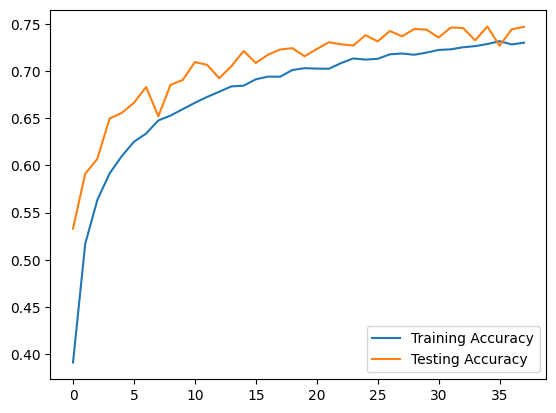

In [34]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Testing Accuracy')
print()
plt.legend()
plt.show()

# Train + evaluate the reference model on full images
- Evaluates the newly merged model on cifar10.
- It can be seen that the merged model, when compared to this reference model, has better metrics

100/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0166 - loss: 4.5998

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0178 - loss: 4.5995


'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


Epoch 1/50


'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


364/391 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1132 - loss: 2.8848

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.1159 - loss: 2.8530 - val_accuracy: 0.2876 - val_loss: 1.9605
Epoch 2/50
  1/391 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.3281 - loss: 1.9836

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2976 - loss: 1.9138 - val_accuracy: 0.4298 - val_loss: 1.5892
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4109 - loss: 1.6240 - val_accuracy: 0.4964 - val_loss: 1.3954
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4698 - loss: 1.4609 - val_accuracy: 0.5284 - val_loss: 1.3063
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5129 - loss: 1.3638 - val_accuracy: 0.5589 - val_loss: 1.2290
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5380 - loss: 1.2953 - val_accuracy: 0.5840 - val_loss: 1.1694
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5542 - loss: 1.2399 - val_accuracy: 0.6099 - val_loss: 1.1174
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5737 - loss: 1.2030 - val_accuracy: 0.6121 - val_loss: 1.0953
Epoch 9/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5817 - loss: 1.1662 - val_accuracy: 0.6300 - val_

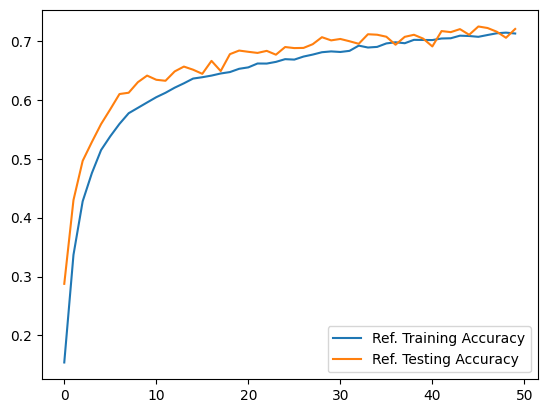

In [35]:
ref_model.evaluate(X_test, y_test)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history = ref_model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test), callbacks=[callback])

model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

plt.plot(history.history['accuracy'], label='Ref. Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Ref. Testing Accuracy')
plt.legend()
plt.show()

It can be seen from the results that the reference model has a worse accuracy when compared to the concatenated one.